### Imports

In [15]:
import xarray as xr
import numpy as np
import pandas as pd
import netCDF4 as nc
import dask
import scipy
import glob
from tqdm import tqdm
from datetime import datetime, timedelta
import netCDF4 as nc
from netCDF4 import Dataset
import geopandas as gpd
import os
import skimage

import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.img_tiles import Stamen
from cartopy.io.img_tiles import MapboxTiles
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings("ignore")

import imageio
import geojson
import requests

from scipy.optimize import curve_fit
import matplotlib as mpl
from matplotlib import font_manager as fm

%matplotlib inline

In [16]:
# 1) Register your new fonts explicitly
font_dir = os.path.expanduser("~/.local/share/fonts")
for path in glob.glob(os.path.join(font_dir, "lm*.otf")):
    fm.fontManager.addfont(path)
for path in glob.glob(os.path.join(font_dir, "cmu*.otf")):
    fm.fontManager.addfont(path)
# Global LaTeX-y defaults
mpl.rcParams.update({
    "text.usetex": False,              # keep mathtext (no TeX required)
    "mathtext.fontset": "cm",          # Computer Modern math
    "axes.unicode_minus": False,

    # Default family = serif (like LaTeX)
    "font.family": "serif",

    # Families mapped to your installed fonts (with sensible fallbacks)
    "font.serif": ["LMRoman10", "CMU Serif", "DejaVu Serif"],
    "font.sans-serif": ["LMSans10", "CMU Sans Serif", "DejaVu Sans"],
    "font.monospace": ["LMMono10", "CMU Typewriter Text", "DejaVu Sans Mono"],
})


### Load Data

In [9]:
initial_detections_df = pd.read_csv('data/initial_detections.csv',)
initial_detections_df['timestamp'] = pd.to_datetime(initial_detections_df['Launch_JD'], unit='D', origin='julian')

In [10]:
launch_df = initial_detections_df.iloc[1]

In [11]:
plume_path = glob.glob(f"plumes/{launch_df.timestamp.strftime('%Y%m%dT%H')}*")[0]
plume_ds = xr.open_dataset(plume_path)['__xarray_dataarray_variable__']

<xarray.Dataset> Size: 5kB
Dimensions:                        (latitude: 25, longitude: 25)
Coordinates:
  * latitude                       (latitude) float32 100B 34.39 34.41 ... 34.87
  * longitude                      (longitude) float32 100B -120.8 ... -120.4
    time                           datetime64[ns] 8B ...
    quantile                       float64 8B ...
Data variables:
    __xarray_dataarray_variable__  (latitude, longitude) float64 5kB ...

In [12]:
from xarray.backends import BackendEntrypoint

class TEMPOBackendEntrypoint(BackendEntrypoint):
    def open_dataset(self, filename_or_obj, drop_variables=None, **kwargs):
        ds = xr.open_dataset(filename_or_obj, group='product',)
        lat, lon, time = self.lat_lon_time(filename_or_obj)
        # Assign new coordinates to the dataset
        ds = ds.assign_coords(latitude=('latitude', lat), longitude=('longitude', lon), time=('time', time))
        try:
            ds['eff_cloud_fraction'] = (['latitude', 'longitude'], self.cloud_fraction(filename_or_obj))
        except:
            pass
        return ds
    
    def lat_lon_time(self, filename_or_obj):
        raw = xr.open_dataset(filename_or_obj,)
        return raw.latitude.values, raw.longitude.values, raw.time.values

    def cloud_fraction(self, filename_or_obj):
        raw = xr.open_dataset(filename_or_obj, group='support_data')
        return raw['eff_cloud_fraction'].values[0]

In [13]:
# access the raw NO2 data
L3_path = glob.glob(f"/home/jpalmo/fs09/Datasets/TEMPO/L3/NO2/TEMPO_NO2_L3_V03_{launch_df.timestamp.strftime('%Y%m%dT%H')}*")[0]
raw_ds = xr.open_dataset(L3_path, group='product', engine=TEMPOBackendEntrypoint)

In [14]:
raw_ds = raw_ds.where(raw_ds['main_data_quality_flag'] == 0)
# cloud filter recommended by TEMPO team
raw_ds = raw_ds.where(raw_ds['eff_cloud_fraction'] < 0.3)

# get bounding box for the launch of interest 2° box surrounding the launch site
launch_lon = launch_df['lon']
launch_lat = launch_df['lat']

box_size = 1
bounding_box = (launch_lon - box_size, launch_lon + box_size, launch_lat - box_size, launch_lat + box_size)
lon_min, lon_max, lat_min, lat_max = bounding_box

# limit the dataset to the bounding box, and subtract the 10th percentile to get enhancements
raw_ds = raw_ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max), drop=True)

## 1b

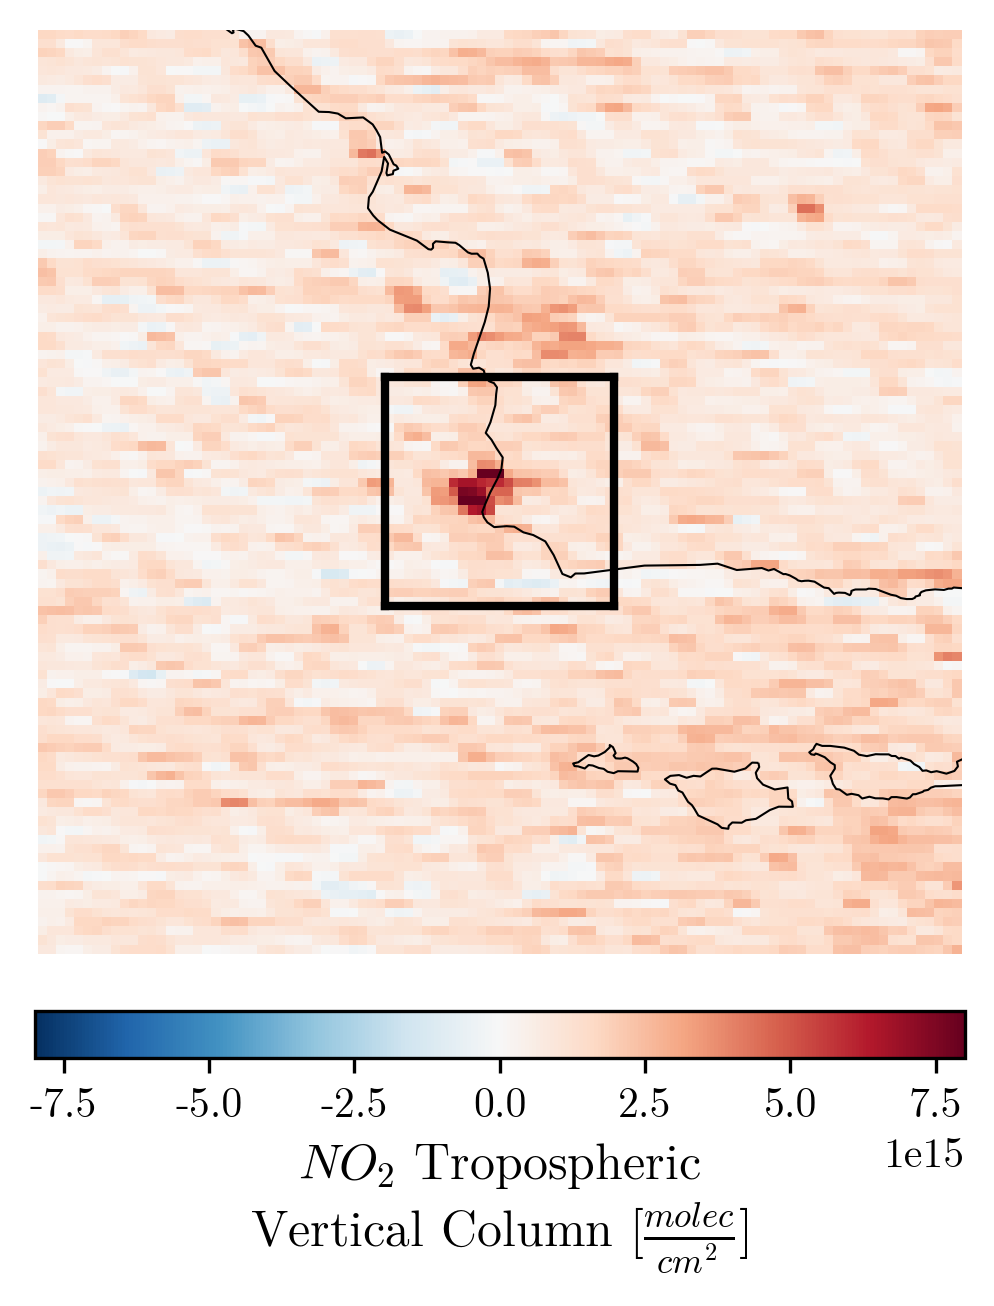

In [17]:
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)

p = raw_ds.vertical_column_troposphere.plot(vmin=-8e15, vmax=8e15, cmap='RdBu_r', add_colorbar=False, ax=ax,)
# plot bounding box
box_size = 0.25
bounding_box = (launch_lon - box_size, launch_lon + box_size, launch_lat - box_size, launch_lat + box_size)
lon_min, lon_max, lat_min, lat_max = bounding_box
plt.plot([lon_min, lon_max], [lat_min, lat_min], color='black', linewidth=2)
plt.plot([lon_min, lon_max], [lat_max, lat_max], color='black', linewidth=2)
plt.plot([lon_min, lon_min], [lat_min, lat_max], color='black', linewidth=2)
plt.plot([lon_max, lon_max], [lat_min, lat_max], color='black', linewidth=2)
plt.title('')

ax.set_axis_off()

# add coastlines and gridlines
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)


# horizontal colorbar
cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label(r'$NO_2$ Tropospheric'+"\n"+ r'Vertical Column [$\frac{molec}{cm^2}$]', fontsize=12)
cbar.ax.tick_params(labelsize=10)

plt.savefig("figures/fig_1b.png", dpi=300)
plt.show()

## 1a

In [23]:
mapbox = cimgt.MapboxTiles(access_token='pk.eyJ1Ijoiam9lcGFsbW8iLCJhIjoiY201Mm1uODJ4Mjd0czJqb2hiMGtnZzF4ZyJ9.lXltNwTUm9dKYJ4UJHjUFQ', map_id = 'satellite-v9', cache=True)

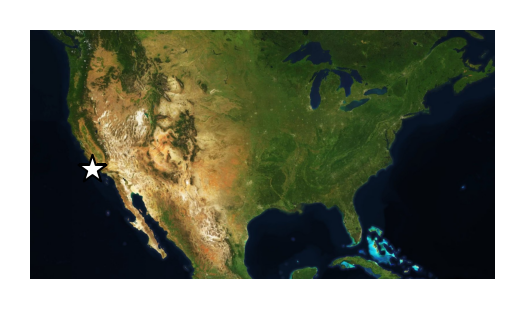

In [19]:
# mapbox map of US with location of plume highlighted
fig, ax = plt.subplots(figsize=(2,2), subplot_kw={'projection': mapbox.crs}, dpi=300)
# set extent to be the US
extent = [-130, -60, 20, 50]
ax.set_extent(extent, crs=ccrs.PlateCarree())
# Add satellite imagery
ax.add_image(mapbox, 4, alpha=1)

# remove axes and background
ax.set_axis_off()

# Plot a star where the launch site is
ax.scatter(launch_lon, launch_lat, marker='*', edgecolor='black', color='white', linewidth=0.5, s=50, transform=ccrs.PlateCarree())

plt.savefig("figures/fig_1a.png", dpi=300)

## 1c

In [25]:
# turn 0s into nans
plume_ds = plume_ds.where(plume_ds != 0)

In [26]:
plume_variable = plume_ds.values
longitude = plume_ds['longitude']
latitude = plume_ds['latitude']

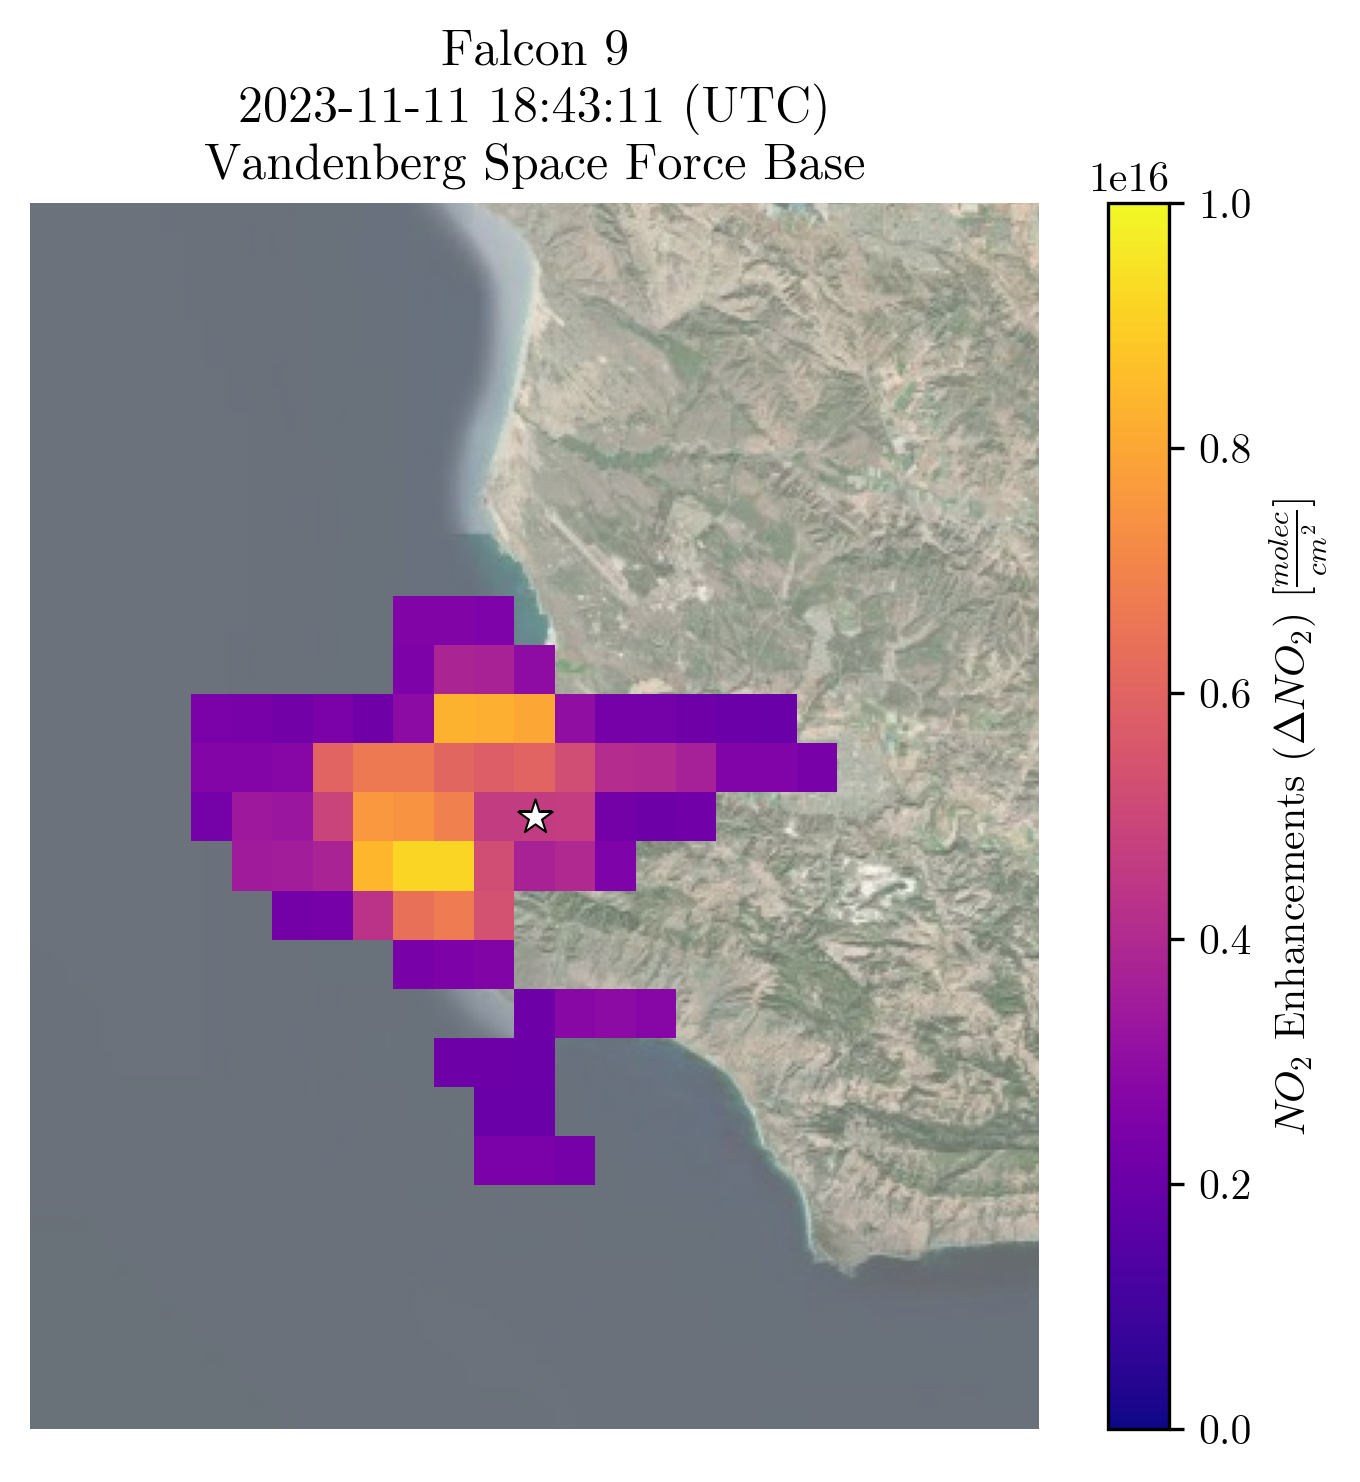

In [27]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': mapbox.crs}, dpi=300)

# set extent to be around the launch site
extent_length = 0.25
extent = [launch_lon-extent_length, launch_lon+extent_length, launch_lat-extent_length, launch_lat+extent_length]
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add satellite imagery
ax.add_image(mapbox, 9, alpha=0.6)

# Plot the pollution data
plume_plot = ax.pcolormesh(
    longitude, latitude, plume_variable,
    transform=ccrs.PlateCarree(),
    cmap='plasma',  # Use a colormap for pollution intensity
    alpha=1,       # Make overlay semi-transparent
    shading='auto',
    vmin=0, vmax=1e16,
)

# Add a colorbar
# cbar = plt.colorbar(plume_plot, ax=ax, orientation='horizontal', pad=0.05, fraction=0.04)
cbar = plt.colorbar(plume_plot, ax=ax, orientation='vertical')
cbar.set_label(r'$NO_2$ Enhancements ($\Delta NO_2$) [$\frac{molec}{cm^2}$]')  # Update units accordingly

# Plot a star where the launch site is
ax.scatter(launch_lon, launch_lat, marker='*', edgecolor='black', color='white', linewidth=0.5, s=75, transform=ccrs.PlateCarree())

ax.set_title(str(launch_df['LV_Type'])+"\n"+str(launch_df.timestamp.strftime('%Y-%m-%d %H:%M:%S (UTC)'))+"\n"+"Vandenberg Space Force Base")

# Show or save the figure
plt.tight_layout()

plt.savefig("figures/fig_1c.png", dpi=300)

ax.set_axis_off()
